In [1]:
import numpy as np
import timeit
import imp
import ZGN_PDE 
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

## Pseudospectral integration

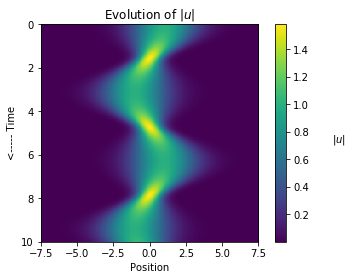

24.360225045


In [2]:
imp.reload(ZGN_PDE)

start=timeit.default_timer()

def dudt(t,u,x):
    uxx = ZGN_PDE.SpectralDiff(u,x[1]-x[0],order=2) 
    return 0.5j*uxx-0.5j*x**2*u

m=500
n=256
tmax=10
L=7.5

dx=2*L/n
dt=tmax/m
x=-L+np.cumsum(dx*np.ones(n))

u0=np.array(np.exp(-(x - 1)**2/5),dtype=np.complex128)
sol=solve_ivp(dudt,[0,tmax], u0, method='BDF', args=[x], t_eval=dt*np.arange(m),rtol=1e-8,atol=1e-8)

u=sol.y.T
t=sol.t
potential=np.zeros((m,n),dtype=np.complex128)
potential[:]=0.5*x**2

plt.imshow(abs(u),extent=(-L,L,tmax,0),aspect=1.5)
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 30
cbar.ax.set_ylabel('$|u|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")
plt.title("Evolution of $|u|$")
plt.show()
stop=timeit.default_timer()
print(stop-start)

## Spectral differentiation

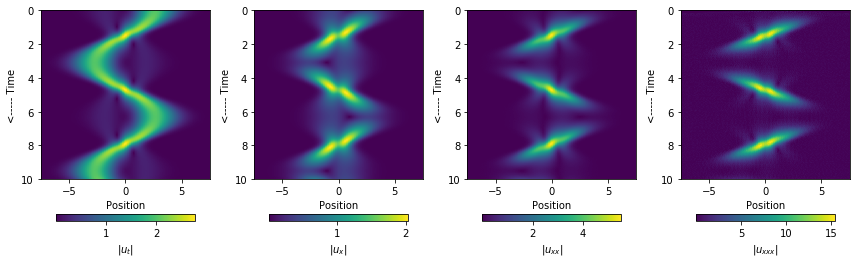

Runtime: 135.188094237


In [3]:
imp.reload(ZGN_PDE)
width=5

start=timeit.default_timer()
m=len(u)-2*width
n=u.shape[1]

ut=np.zeros((m,n),dtype=np.complex128)

for i in range(n):
    pdr=ZGN_PDE.PolyDiff(np.real(u[:,i]), dt*np.arange(len(u)), diff=1,width=width)
    pdi=ZGN_PDE.PolyDiff(np.imag(u[:,i]), dt*np.arange(len(u)), diff=1,width=width)
    ut[:,i] = pdr[:,0]+1j*pdi[:,0]
    
ux=ZGN_PDE.SpectralDiff(u,dx,axis=1,order=1)[width:-width]
uxx=ZGN_PDE.SpectralDiff(u,dx,axis=1,order=2)[width:-width]
uxxx=ZGN_PDE.SpectralDiff(u,dx,axis=1,order=3)[width:-width]

plt.subplots(1,4,figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(np.abs(ut),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_t|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")

plt.subplot(1,4,2)
plt.imshow(np.abs(ux),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_x|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")

plt.subplot(1,4,3)
plt.imshow(np.abs(uxx),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_{xx}|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")

plt.subplot(1,4,4)
plt.imshow(np.abs(uxxx),extent=(-7.5,7.5,10,0),aspect=1.5)
cbar = plt.colorbar(fraction=0.03,orientation="horizontal")
cbar.ax.set_xlabel('$|u_{xxx}|$', rotation=0)
plt.xlabel("Position")
plt.ylabel("<----- Time")

plt.tight_layout()
plt.show()

ut = np.reshape(ut, (n*m,1), order='F')
ux = np.reshape(ux, (n*m,1), order='F')
uxx = np.reshape(uxx, (n*m,1), order='F')
uxxx = np.reshape(uxxx, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ux,uxx,uxxx])
X_data = np.hstack([np.reshape(u[width:-width], (n*m,1), order='F'), 
                    np.reshape(abs(u[width:-width]), (n*m,1), order='F'), 
                    np.reshape(potential[width:-width], (n*m,1), order='F')])
derivatives_description = ['','u_{x}','u_{xx}', 'u_{xxx}']

X, descr = ZGN_PDE.build_Theta(X_data, X_ders, derivatives_description, 2, data_description = ['u','|u|','V'])

stop=timeit.default_timer()
print("Runtime:", stop-start)

## Individual runs

In [4]:
imp.reload(ZGN_PDE)

w=ZGN_PDE.STRidge(X, ut, 0.005, 10, 50, normalize = 2, print_results = True)
ZGN_PDE.print_pde(w,descr)
print(np.linalg.norm(ut-X.dot(w))/len(ut)**0.5)

w=ZGN_PDE.STRidge(X, ut, 0.005, 10, 0.1, normalize = 0, print_results = True)
ZGN_PDE.print_pde(w,descr)
print(np.linalg.norm(ut-X.dot(w))/len(ut)**0.5)

iter, terms: 0 40
iter, terms: 1 16
iter, terms: 2 2
u_t = (-0.000583 +0.499821i)u_{xx}
    + (0.001189 -0.999692i)uV
   
0.0032658243265928115
iter, terms: 0 40
iter, terms: 1 2
u_t = (-0.000583 +0.499821i)u_{xx}
    + (0.001189 -0.999692i)uV
   
0.0032658243265928106


## Parameter sweep

In [9]:
num=25
tolmax=0.6
lambdamax=0.1
lambdas=lambdamax*np.arange(1,num+1)/num
tols=tolmax*np.arange(1,num+1)/num
testerr=np.zeros((num,num))
trainerr=np.zeros((num,num))
terms=np.zeros((num,num))
cs=np.zeros((num,num,2))
start=timeit.default_timer()
split=0.5
noise=0.1

for i in range(num):
    for j in range(num):
        n=len(X)
        train=np.arange(int(n*split))
        test = np.setdiff1d(np.arange(n),train)
        tol=tols[i]
        lam=lambdas[j]
        print("%f %f\r"%(tol,lam),end='')
        utrain=ut[train]+noise*np.random.randn(ut[train].shape[0], ut[train].shape[1])
        utest=ut[test]#+noise*np.random.randn(ut[test].shape[0], ut[test].shape[1])
        w=ZGN_PDE.STRidge(X[train], utrain, lam, 10, tol, normalize = 0)
        trainerr[i,j]=np.linalg.norm(ut[train]-X[train].dot(w))/len(train)**0.5
        testerr[i,j]=np.linalg.norm(ut[test]-X[test].dot(w))/len(test)**0.5
        terms[i,j]=np.count_nonzero(w)
        cs[i,j]=[tol/tolmax,lam/lambdamax]
        
stop=timeit.default_timer()
print("Runtime:", stop-start)

Runtime: 117.79147102599995


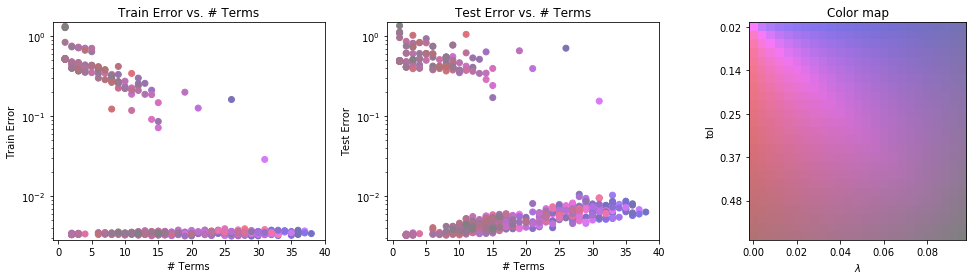

In [10]:
def xy_color_func(xy):
    # using np.divide handles `RuntimeWarning: divide by zero encountered in true_divide`
    xy_ratio = np.divide(xy.T[1], xy.T[0], out=np.ones_like(xy.T[0]), where=(xy.T[0]!=0) )
    xy_angle_frac = (4/np.pi)*np.abs(np.arctan(xy_ratio))
    xy_mag = np.linalg.norm(xy, axis=-1)
    hsl_hue = 1 - 1./6*xy_angle_frac   # hue goes from red to blue 
    hsl_sat = 1 - xy_mag/xy_mag.max()  # 0 is full color saturation, 1 is equal RGB values
    hsl_luminance = 0.75 - 0.25*(xy_mag/xy_mag.max())  # brighter at the "target" point of (0, 0)
    hsv = hsl_to_hsv(hsl_hue, hsl_sat, hsl_luminance)
    rgb = hsv_to_rgb(hsv)
    return rgb

def hsl_to_hsv(hsl_hue, hsl_sat, hsl_luminance):
    hsv_hue = hsl_hue
    hsv_v = hsl_luminance + hsl_sat*np.minimum(hsl_luminance, 1-hsl_luminance)
    hsv_sat = 2*(1-np.divide(hsl_luminance, hsv_v, out=np.ones_like(hsv_v), where=(hsv_v!=0) ))
    hsv = np.vstack((hsv_hue, hsv_sat, hsv_v)).T
    return hsv

xy_colors = xy_color_func(np.reshape(cs,(num*num,2)))


fig, ax = plt.subplots(1,3, figsize=(14,4))

plot=ax[0].scatter(np.reshape(terms,num*num),np.reshape(trainerr,num*num),c=xy_colors)
ax[0].set_yscale('log')
ax[0].set_xlabel("# Terms")
ax[0].set_ylabel("Train Error")
ax[0].set_title("Train Error vs. # Terms")
ax[0].set_xticks(range(0,41,5))
ax[0].set_ylim([0.9*np.min([trainerr,testerr]),1.1*np.max([trainerr,testerr])])

plot=ax[1].scatter(np.reshape(terms,num*num),np.reshape(testerr,num*num),c=xy_colors)
ax[1].set_yscale('log')
ax[1].set_xlabel("# Terms")
ax[1].set_ylabel("Test Error")
ax[1].set_title("Test Error vs. # Terms")
ax[1].set_xticks(range(0,41,5))
ax[1].set_ylim([0.9*np.min([trainerr,testerr]),1.1*np.max([trainerr,testerr])])

plot=ax[2].imshow(np.reshape(xy_colors,(num,num,3)),aspect=1)
ax[2].set_xlabel("$\lambda$")
ax[2].set_ylabel("tol")
ax[2].set_title("Color map")
ax[2].set_xticklabels(["%.2f"%((x+1)/(num+1)*lambdamax) for x in ax[2].get_xticks()])
ax[2].set_yticklabels(["%.2f"%((y+1)/(num+1)*tolmax) for y in ax[2].get_yticks()])

plt.tight_layout()
plt.show()
